In [16]:
from pathlib import Path
import sys

sys.path.append((Path.cwd().parent).as_posix())

In [2]:
from tdc.single_pred import ADME
from alien.data import DeepChemDataset

data = ADME(name = 'Caco2_Wang')
split = data.get_split()

data = DeepChemDataset(
    X=split['train']['Drug'], 
    y=list(split['train']['Y']), 
    featurizer='molgraphconv'
)
test_data = DeepChemDataset(
    X=split['test']['Drug'], 
    y=list(split['test']['Y']), 
    featurizer='molgraphconv'
)

Found local copy...
Loading...
Done!
2023-05-03 07:04:22.375647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 07:04:22.423724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 07:04:22.424500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 07:04:23.176417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.to

In [3]:
import deepchem as dc
import os
import torch

hyper_params_small = {
    "predictor_hidden_feats": 50,
    "graph_conv_layers": [20, 20],
    "activation": torch.nn.ReLU(),
    "dropout": 0.1,
    "batchnorm": True,
    "learning_rate": 0.001,
}

os.makedirs("deepchem_pytorch_models", exist_ok=True)
dc_model = dc.models.GCNModel(
    1,
    batch_size=64,
    mode="regression",
    uncertainty=False,
    log_frequency=20,
    model_dir="deepchem_pytorch_models/",
    # This looks stupid, but you need to set devce='cpu' if you want to use
    # Pytorch Lightning with the GPU:
    device="cpu",
    **hyper_params_small
)

In [4]:
from alien.models import DeepChemLaplaceRegressor

# We may not have a GPU on this computer, so we comment it out.
# Since we're using Pytorch lightning under the hood, we can
# pass any arguments which would go to the Pytorch lightning
# trainer.
model = DeepChemLaplaceRegressor(dc_model, data) #, accelerator="gpu")

In [5]:
model.fit(nb_epoch=40) #, accelerator="gpu")  # , strategy="ddp")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 4.4 K 
-------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Epoch 39:  80%|████████  | 8/10 [00:00<00:00, 20.05it/s, loss=0.64, v_num=2]  

`Trainer.fit` stopped: `max_steps=398` reached.


Epoch 39:  80%|████████  | 8/10 [00:00<00:00, 19.74it/s, loss=0.64, v_num=2]
Fitting Laplace approximation...


In [6]:
pred = model.predict(test_data[:40, "X"])
cov = model.covariance(test_data[:40, "X"])

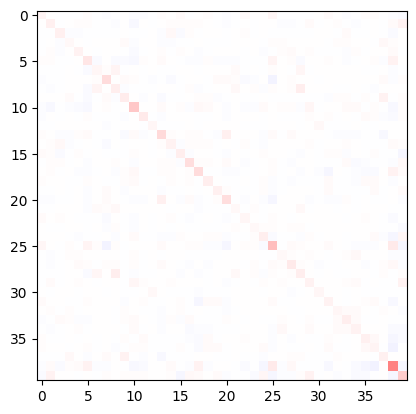

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cov, cmap="bwr", vmin=-1, vmax=1, interpolation="nearest")
plt.show()

In [9]:
def cor_from_cov(cov):
    std = 1 / np.sqrt(np.diag(cov))
    return std[:, None] * cov * std[None, :]

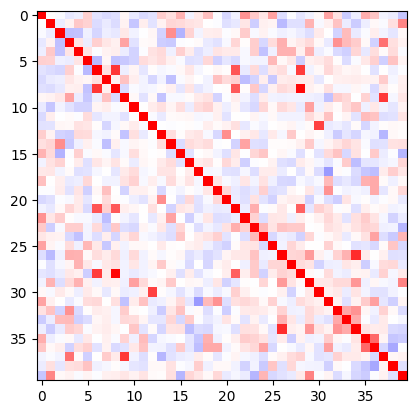

In [10]:
import matplotlib.pyplot as plt
import numpy as np

corr = cor_from_cov(cov)
plt.imshow(corr, cmap="bwr", vmin=-1, vmax=1, interpolation="nearest")
plt.show()

In [11]:
from alien.selection import BAITSelector

selector = BAITSelector(
    model=model,
    samples=data.X,
    batch_size=20,
    random_seed=420,
)

In [12]:
batch_0 = selector.select()
selector.labelled_samples = batch_0

batch_1 = selector.select()

Greedy forward sampling...
Greedy backward pruning...


In [13]:
from alien.models import DeepChemMCDropoutRegressor

mc_model = DeepChemMCDropoutRegressor(dc_model, data)

In [14]:
from alien.selection import CovarianceSelector

selector = CovarianceSelector(
    model=mc_model,
    samples=data.X,
    batch_size=20,
    random_seed=420,
)

In [15]:
batch_0 = selector.select()
selector.labelled_samples = batch_0

batch_1 = selector.select()